In [1]:
import requests
from bs4 import BeautifulSoup
import pymysql
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
import ast
import wordcloud

In [2]:
connection = pymysql.connect(
    host='localhost',  # 127.0.0.1
    user='root',
    password='12345678',
    database='ds'
)

## Scraping data (already done)

In [126]:
def get_inner_content(news_url: str) -> str:
    inner_response = requests.get(news_url)
    inner_soup = BeautifulSoup(inner_response.content, 'lxml')
    content_div = inner_soup.find('div', class_='newsin_text clearfix')
    content_sentences = list()
    all_paragraphs = content_div.find_all('p')
    for paragraph in all_paragraphs:
        content_sentences.append(paragraph.get_text())

    joined = ' '.join(content_sentences).replace(u'\xa0', u' ')
    return joined


def fetch_data():
    for i in range(1, 2501):
        page_count = i
        base_url = f"https://azedu.az/az/news/page/{page_count}/"
        response = requests.get(base_url)
        soup = BeautifulSoup(response.content, 'lxml')
        container = soup.find('div', class_="mleft_twopart clearfix")
        urls = container.find_all('a')
        for url in urls:
            url_text = url.get('href')
            title = url.get('title')
            inner_content = get_inner_content(url_text)
            insert_sql = 'insert into sentiment_data (title,content,url) values(%s, %s, %s)'
            values = (title, inner_content, url_text)
            with connection.cursor() as cursor:
                cursor.execute(insert_sql, values)
                connection.commit()
        print(f"Page {page_count} has completed")




In [127]:
# fetch_data()

In [8]:
df = pd.read_sql("select * from sentiment_data", connection)

C:\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [11]:
df = pd.read_csv('azedu_sentiment.csv')

In [12]:
df.shape

(43617, 5)

In [130]:
# !pip install textblob

In [131]:
from textblob import TextBlob
from textblob import Word

# Translating to English

### In order to decrease the total time, I have implemented translation with multithreading in seperate py script and wrote it to news_english.pkl file.
#### Check: translate_contents.py

## Data cleaning

In [132]:
data = pd.read_pickle('news_english.pkl')

In [133]:
data = data.iloc[:30000]

In [134]:
data.tail

### Some contents are empty so I am going to get rid of those rows first

In [135]:
data[data.content == '']

,content
92,
148,
234,
287,
299,
...,...
29294,
29786,
29811,
29847,


In [136]:
data = data[~(data.content == '')]

In [137]:
def clean_text1(text: str):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


clean_text_lambda1 = lambda x: clean_text1(x)

In [138]:
data = pd.DataFrame(data.content.apply(clean_text_lambda1))

In [139]:
data.content

0        receipt of documents to vocational schools tod...
1        while studying studies the study proved to hav...
2        acceptance of documents for high schools and g...
3        exam dim will be held in the building located ...
4        rector of tashkent state transport university ...
                               ...                        
29995    one of the important steps to take into accoun...
29996    we present the following article of writtons i...
29997    azeduaz regularly answers applicants students ...
29998    from april  the movement is restricted in orde...
29999    due to the spread of the  epidemic the final e...
Name: content, Length: 29614, dtype: object

In [140]:

def clean_text2(text: str):
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text


clean_text_lambda2 = lambda x: clean_text2(x)

In [141]:
data = pd.DataFrame(data.content.apply(clean_text_lambda2))

In [142]:
data.content

0        receipt of documents to vocational schools tod...
1        while studying studies the study proved to hav...
2        acceptance of documents for high schools and g...
3        exam dim will be held in the building located ...
4        rector of tashkent state transport university ...
                               ...                        
29995    one of the important steps to take into accoun...
29996    we present the following article of writtons i...
29997    azeduaz regularly answers applicants students ...
29998    from april  the movement is restricted in orde...
29999    due to the spread of the  epidemic the final e...
Name: content, Length: 29614, dtype: object

### Removing stop words

In [144]:
from nltk.corpus import stopwords
import re

stop_words = stopwords.words('english')
data['content'] = data['content'].apply(lambda x: ' '.join(x for x in re.split('\s+', x) if x not in stop_words))

In [145]:
data.content

0        receipt documents vocational schools today com...
1        studying studies study proved positive impact ...
2        acceptance documents high schools gymnasiums i...
3        exam dim held building located abdulvahab sala...
4        rector tashkent state transport university odi...
                               ...                        
29995    one important steps take account parents pay c...
29996    present following article writtons history sec...
29997    azeduaz regularly answers applicants students ...
29998    april movement restricted order prevent spread...
29999    due spread epidemic final exams france organiz...
Name: content, Length: 29614, dtype: object

## Spelling correction

#### Don't run the code below unless you have enough patience to wait for hours :D

In [146]:
# data['content'] = data['content'].apply(lambda x: str(TextBlob(x).correct()))

In [147]:
data.head().content

0    receipt documents vocational schools today com...
1    studying studies study proved positive impact ...
2    acceptance documents high schools gymnasiums i...
3    exam dim held building located abdulvahab sala...
4    rector tashkent state transport university odi...
Name: content, dtype: object

In [148]:
import nltk

nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\maham\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\maham\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\maham\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\maham\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\maham\AppData\Roaming\nltk_data...
[nltk_data]    | 

True

In [149]:
!python -m textblob.download_corpora

Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\maham\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maham\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\maham\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\maham\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!

## Lemmatisation

In [150]:
data['content'] = data['content'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in re.split('\s+', x)]))

In [151]:
data.content

0        receipt document vocational school today compl...
1        studying study study proved positive impact hu...
2        acceptance document high school gymnasium impl...
3        exam dim held building located abdulvahab sala...
4        rector tashkent state transport university odi...
                               ...                        
29995    one important step take account parent pay chi...
29996    present following article writtons history sec...
29997    azeduaz regularly answer applicant student edu...
29998    april movement restricted order prevent spread...
29999    due spread epidemic final exam france organize...
Name: content, Length: 29614, dtype: object

In [152]:
!pip install vaderSentiment

     ------------------------------------ 126.0/126.0 kB 618.8 kB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [154]:
cp = sns.color_palette()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [157]:
sentiment_rows = []
for row in data.content:
    vaderSentiment = analyzer.polarity_scores(row)
    sentiment_rows.append(vaderSentiment)

df_sentiment = pd.DataFrame(sentiment_rows)
df_sentiment.head()

,neg,neu,pos,compound
0,0.000,0.858,0.142,0.9201
1,0.046,0.810,0.144,0.8604
2,0.000,0.919,0.081,0.6124
3,0.035,0.965,0.000,-0.2960
4,0.000,0.973,0.027,0.3400


In [159]:
data = pd.concat([data.reset_index(drop=True), df_sentiment], axis=1)
data.head()

,content,neg,neu,pos,compound
0,receipt document vocational school today compl...,0.000,0.858,0.142,0.9201
1,studying study study proved positive impact hu...,0.046,0.810,0.144,0.8604
2,acceptance document high school gymnasium impl...,0.000,0.919,0.081,0.6124
3,exam dim held building located abdulvahab sala...,0.035,0.965,0.000,-0.2960
4,rector tashkent state transport university odi...,0.000,0.973,0.027,0.3400


In [161]:
data['sentiment'] = np.where(data['compound'] >= 0, 'Positive', 'Negative')
data.head()

,content,neg,neu,pos,compound,sentiment
0,receipt document vocational school today compl...,0.000,0.858,0.142,0.9201,Positive
1,studying study study proved positive impact hu...,0.046,0.810,0.144,0.8604,Positive
2,acceptance document high school gymnasium impl...,0.000,0.919,0.081,0.6124,Positive
3,exam dim held building located abdulvahab sala...,0.035,0.965,0.000,-0.2960,Negative
4,rector tashkent state transport university odi...,0.000,0.973,0.027,0.3400,Positive


<AxesSubplot:>

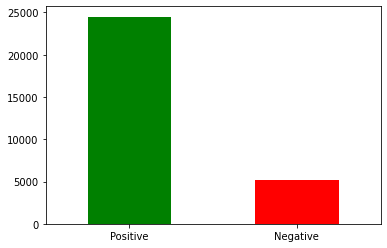

In [169]:
result = data['sentiment'].value_counts()
result.plot(kind='bar', rot=0, color=['green', 'red'])

In [174]:
positive_content = data[data.sentiment == 'Positive']
negative_content = data[data.sentiment == 'Negative']

positive_content_str = positive_content.content.str.cat()
negative_content_str = negative_content.content.str.cat()

## Wordcloud

In [187]:
wordcloud_positive = wordcloud.WordCloud(height=800, width=1600, background_color='white',
                                         stopwords=wordcloud.STOPWORDS).generate(positive_content_str)
wordcloud_negative = wordcloud.WordCloud(height=800, width=1600, background_color='white',
                                         stopwords=wordcloud.STOPWORDS).generate(negative_content_str)


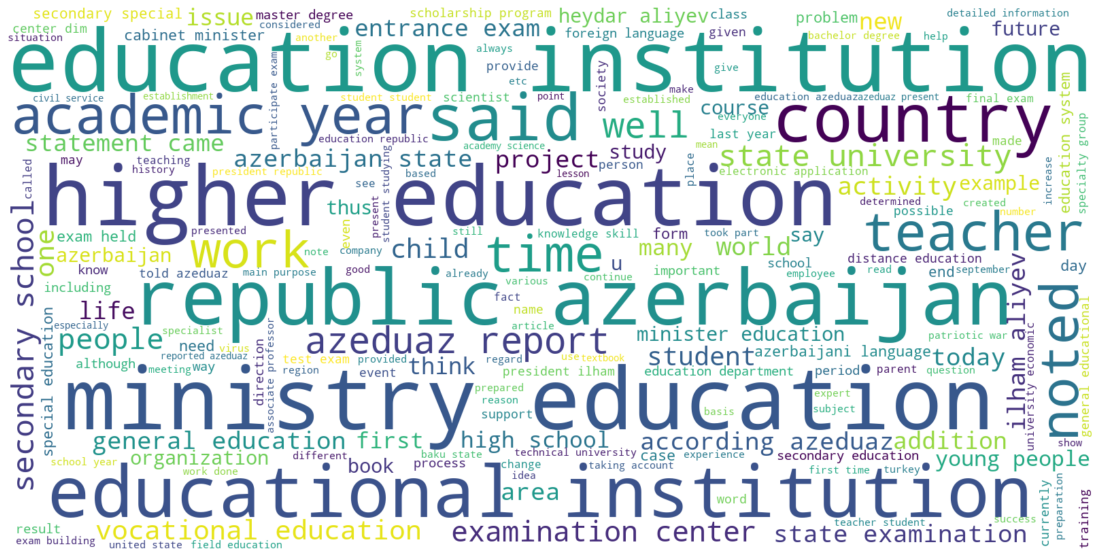

In [191]:
plt.figure(figsize=(20, 10))
plt.axis("off")
plt.imshow(wordcloud_positive, interpolation='bilinear')

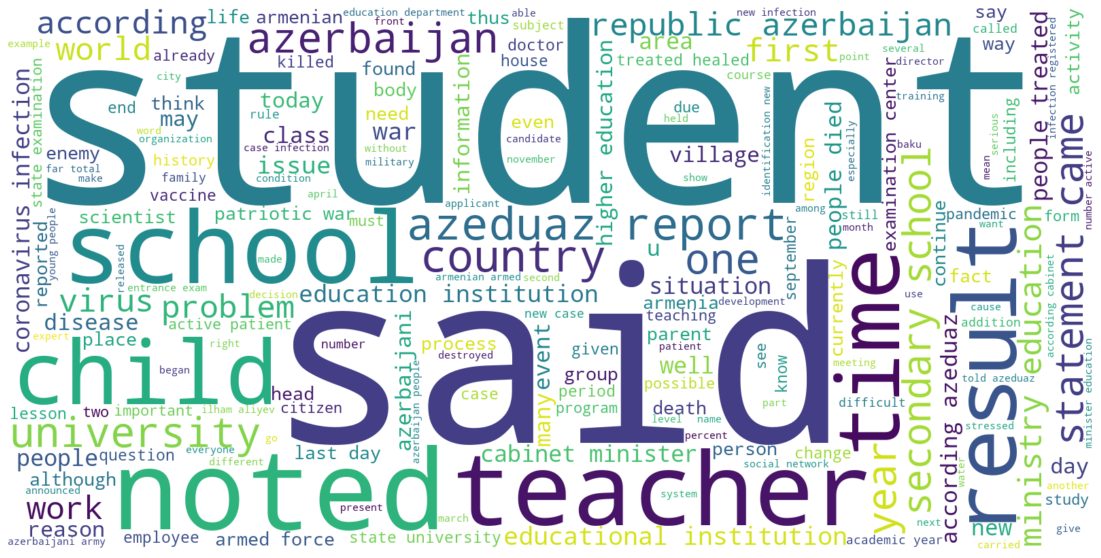

In [195]:
plt.figure(figsize=(20, 10))
plt.axis("off")
plt.imshow(wordcloud_negative, interpolation='bilinear')

In [196]:
data.to_pickle("sentiment_completed.pkl")